# AutoDL Implementation Part - 1
#### Dataset Used: Keylogger_Detection Dataset
#### (The preprocessed dataset of the original dataset is used for implementation)

## Importing Required Libraries

In [1]:
import sys
sys.path.append('C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python37\\Lib\\site-packages')
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from plotly import graph_objs as go
import plotly.figure_factory as ff
from tqdm import tqdm
import tensorflow as tf

#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
import keras
# Conv1D + LSTM
from keras.layers.convolutional import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.layers import GlobalMaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, LSTM, Dense, Flatten

from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50

from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


In [23]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Acessing Dataset from User

In [2]:
path=input("Enter the Dataset Path: \n")

Enter the Dataset Path: 
Keylogger_Updated.csv


In [3]:
inp=int(input("Enter the Type of dataset:\n1.Text\n2.CSV\n3.Excel\n4.Image\n5.Audio\n"))

Enter the Type of dataset:
1.Text
2.CSV
3.Excel
4.Image
5.Audio
2


In [4]:
if inp==1:
    delim=input("Enter the delimiter present for given dataset:")
    df = pd.read_csv(path, delimiter=delim)
elif inp==2:
    df = pd.read_csv(path)
elif inp==3:  
    df = pd.read_excel(path)
elif inp==4:
    Image_Width = 512
    Image_Height = 512
    Image_Size = (Image_Width, Image_Height)
    train_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,)
    test_generator = test_datagen.flow_from_directory(path,
                                                  target_size=Image_Size,
                                                  batch_size = 32,
                                                  class_mode='categorical')
    test_datagen = ImageDataGenerator(rescale=1./255)
elif inp==5:
    print(5)

## Reading the Dataset 

In [5]:
df.head(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,-0.210447,-0.368579,-0.468868,0.042412,-0.004811,-0.036722,-0.013233,-0.038629,-0.021233,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
1,0.828487,-0.368579,-0.468868,-0.465677,0.945480,0.575336,-0.004001,0.556642,0.815442,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
2,-2.027848,2.839488,-0.468868,-0.483831,-0.076338,-0.055364,-0.018437,-0.046536,-0.435509,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
3,-0.821057,-0.393449,2.036972,-0.460353,-0.086556,-0.052257,-0.018736,-0.046050,-0.478832,0.522899,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
4,0.759549,-0.368579,-0.468868,-0.166949,-0.066120,-0.055364,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004135,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0


In [6]:
df.groupby('label').size()

label
0    308813
1    214782
dtype: int64

In [7]:
target=['label']
features = [c for c in df.columns if c!="label"]

## Train Test Split

In [8]:
X = df[features].values # Features
y = df[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((523595, 67), (523595, 1))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [10]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((418876, 67), (104719, 67), (418876, 1), (104719, 1))

In [11]:
DLmodels = []
DLhistory=[]
AUCVal=[]

# Deep Learning Model 1 -ANN

In [12]:
learning_rate=0.001
batch_size=512
epochs = 1000

model_save = ModelCheckpoint('./Keylogging.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 50, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.75, 
                              patience = 10, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [13]:
def Create_Model_ANN(num_columns, num_labels,learning_rate):
    model = Sequential()
    model.add(Dense(64,input_dim=num_columns, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_labels,activation='sigmoid'))
    
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #adam = Adam(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=adam,metrics=[keras.metrics.AUC(name='auc')])
    
    return model

model = Create_Model_ANN(X_test.shape[1], 1,learning_rate)

C:\Users\hp\AppData\Local\Programs\Python\Python37\Lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
input_size=X_train.shape[1] # 50

model1 = keras.Sequential()
# Add input layer 50 

w0=model.layers[0].get_weights()[0][:,:]
b0=model.layers[0].get_weights()[1]

model1.add(Dense(64,input_dim=input_size, activation='relu'))
model1.layers[0].set_weights([w0, b0])

# Add trained layers (with weight)
for layer in model.layers[1:7]:
    model1.add(layer)
    
# add output layer  sigmoid or softmax..    
model1.add(Dense(1,activation='sigmoid'))
#model_new.layers[0].set_weights([w0, b0])

adam = Adam(lr=learning_rate)
model1.compile(loss='binary_crossentropy', optimizer=adam,metrics=[keras.metrics.AUC(name='auc')])

In [15]:
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                4352      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)               

In [16]:
history1=model1.fit(X_train,
          y_train,
          validation_data=(X_test,y_test),
          callbacks = [model_save, early_stop, reduce_lr],
          verbose=1,
          batch_size=batch_size,
          epochs=epochs)


Epoch 1/1000
818/819 [============================>.] - ETA: 0s - loss: 0.6458 - auc: 0.6267
Epoch 1: val_loss improved from inf to 0.63850, saving model to .\Keylogging.h5
819/819 [==============================] - 14s 16ms/step - loss: 0.6458 - auc: 0.6267 - val_loss: 0.6385 - val_auc: 0.6474 - lr: 0.0010
Epoch 2/1000
816/819 [============================>.] - ETA: 0s - loss: 0.6274 - auc: 0.6563
Epoch 2: val_loss improved from 0.63850 to 0.62237, saving model to .\Keylogging.h5
819/819 [==============================] - 14s 17ms/step - loss: 0.6273 - auc: 0.6563 - val_loss: 0.6224 - val_auc: 0.6643 - lr: 0.0010
Epoch 3/1000
817/819 [============================>.] - ETA: 0s - loss: 0.6189 - auc: 0.6692
Epoch 3: val_loss improved from 0.62237 to 0.61735, saving model to .\Keylogging.h5
819/819 [==============================] - 16s 19ms/step - loss: 0.6188 - auc: 0.6692 - val_loss: 0.6173 - val_auc: 0.6730 - lr: 0.0010
Epoch 4/1000
819/819 [==============================] - ETA: 0s -

Epoch 28/1000
816/819 [============================>.] - ETA: 0s - loss: 0.5195 - auc: 0.7834
Epoch 28: val_loss improved from 0.53068 to 0.53033, saving model to .\Keylogging.h5
819/819 [==============================] - 16s 19ms/step - loss: 0.5195 - auc: 0.7835 - val_loss: 0.5303 - val_auc: 0.7764 - lr: 0.0010
Epoch 29/1000
817/819 [============================>.] - ETA: 0s - loss: 0.5165 - auc: 0.7868
Epoch 29: val_loss improved from 0.53033 to 0.52757, saving model to .\Keylogging.h5
819/819 [==============================] - 16s 19ms/step - loss: 0.5165 - auc: 0.7868 - val_loss: 0.5276 - val_auc: 0.7781 - lr: 0.0010
Epoch 30/1000
816/819 [============================>.] - ETA: 0s - loss: 0.5136 - auc: 0.7892
Epoch 30: val_loss improved from 0.52757 to 0.52715, saving model to .\Keylogging.h5
819/819 [==============================] - 14s 17ms/step - loss: 0.5135 - auc: 0.7893 - val_loss: 0.5272 - val_auc: 0.7799 - lr: 0.0010
Epoch 31/1000
819/819 [==============================] 

819/819 [==============================] - 16s 19ms/step - loss: 0.4692 - auc: 0.8278 - val_loss: 0.4982 - val_auc: 0.8136 - lr: 0.0010
Epoch 56/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4685 - auc: 0.8287
Epoch 56: val_loss did not improve from 0.49597
819/819 [==============================] - 17s 20ms/step - loss: 0.4684 - auc: 0.8287 - val_loss: 0.4975 - val_auc: 0.8141 - lr: 0.0010
Epoch 57/1000
816/819 [============================>.] - ETA: 0s - loss: 0.4663 - auc: 0.8306
Epoch 57: val_loss improved from 0.49597 to 0.49508, saving model to .\Keylogging.h5
819/819 [==============================] - 16s 19ms/step - loss: 0.4664 - auc: 0.8305 - val_loss: 0.4951 - val_auc: 0.8152 - lr: 0.0010
Epoch 58/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4655 - auc: 0.8312
Epoch 58: val_loss improved from 0.49508 to 0.49234, saving model to .\Keylogging.h5
819/819 [==============================] - 15s 19ms/step - loss: 0.4655 - auc: 0.8312 - val_

Epoch 84/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4379 - auc: 0.8536
Epoch 84: val_loss did not improve from 0.47189
819/819 [==============================] - 23s 28ms/step - loss: 0.4379 - auc: 0.8536 - val_loss: 0.4811 - val_auc: 0.8322 - lr: 0.0010
Epoch 85/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4358 - auc: 0.8552
Epoch 85: val_loss improved from 0.47189 to 0.47124, saving model to .\Keylogging.h5
819/819 [==============================] - 22s 27ms/step - loss: 0.4358 - auc: 0.8552 - val_loss: 0.4712 - val_auc: 0.8379 - lr: 0.0010
Epoch 86/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4354 - auc: 0.8557
Epoch 86: val_loss did not improve from 0.47124
819/819 [==============================] - 25s 31ms/step - loss: 0.4354 - auc: 0.8557 - val_loss: 0.4714 - val_auc: 0.8394 - lr: 0.0010
Epoch 87/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4339 - auc: 0.8563
Epoch 87: val_loss did not improve 

Epoch 112/1000
819/819 [==============================] - ETA: 0s - loss: 0.4135 - auc: 0.8717
Epoch 112: val_loss did not improve from 0.45764
819/819 [==============================] - 14s 17ms/step - loss: 0.4135 - auc: 0.8717 - val_loss: 0.4605 - val_auc: 0.8532 - lr: 0.0010
Epoch 113/1000
818/819 [============================>.] - ETA: 0s - loss: 0.4115 - auc: 0.8729
Epoch 113: val_loss improved from 0.45764 to 0.45712, saving model to .\Keylogging.h5
819/819 [==============================] - 15s 18ms/step - loss: 0.4115 - auc: 0.8728 - val_loss: 0.4571 - val_auc: 0.8551 - lr: 0.0010
Epoch 114/1000
818/819 [============================>.] - ETA: 0s - loss: 0.4106 - auc: 0.8733
Epoch 114: val_loss did not improve from 0.45712
819/819 [==============================] - 16s 19ms/step - loss: 0.4106 - auc: 0.8733 - val_loss: 0.4577 - val_auc: 0.8561 - lr: 0.0010
Epoch 115/1000
817/819 [============================>.] - ETA: 0s - loss: 0.4110 - auc: 0.8734
Epoch 115: val_loss improved

Epoch 168/1000
818/819 [============================>.] - ETA: 0s - loss: 0.3136 - auc: 0.9293
Epoch 168: val_loss did not improve from 0.42810
819/819 [==============================] - 23s 28ms/step - loss: 0.3136 - auc: 0.9293 - val_loss: 0.4337 - val_auc: 0.9038 - lr: 4.2187e-04
Epoch 169/1000
818/819 [============================>.] - ETA: 0s - loss: 0.3124 - auc: 0.9297
Epoch 169: val_loss did not improve from 0.42810
819/819 [==============================] - 30s 37ms/step - loss: 0.3124 - auc: 0.9297 - val_loss: 0.4299 - val_auc: 0.9054 - lr: 4.2187e-04
Epoch 170/1000
816/819 [============================>.] - ETA: 0s - loss: 0.3106 - auc: 0.9307
Epoch 170: val_loss did not improve from 0.42810
819/819 [==============================] - 19s 23ms/step - loss: 0.3106 - auc: 0.9307 - val_loss: 0.4358 - val_auc: 0.9048 - lr: 4.2187e-04
Epoch 171/1000
816/819 [============================>.] - ETA: 0s - loss: 0.3105 - auc: 0.9309
Epoch 171: val_loss did not improve from 0.42810
819/

818/819 [============================>.] - ETA: 0s - loss: 0.2478 - auc: 0.9571
Epoch 196: val_loss did not improve from 0.42810
819/819 [==============================] - 19s 23ms/step - loss: 0.2478 - auc: 0.9571 - val_loss: 0.5026 - val_auc: 0.9299 - lr: 1.7798e-04
Epoch 197/1000
817/819 [============================>.] - ETA: 0s - loss: 0.2458 - auc: 0.9578
Epoch 197: val_loss did not improve from 0.42810
819/819 [==============================] - 22s 27ms/step - loss: 0.2458 - auc: 0.9578 - val_loss: 0.5063 - val_auc: 0.9300 - lr: 1.7798e-04
Epoch 198/1000
818/819 [============================>.] - ETA: 0s - loss: 0.2450 - auc: 0.9580
Epoch 198: val_loss did not improve from 0.42810
819/819 [==============================] - 24s 30ms/step - loss: 0.2450 - auc: 0.9580 - val_loss: 0.5124 - val_auc: 0.9320 - lr: 1.7798e-04
Epoch 199/1000
817/819 [============================>.] - ETA: 0s - loss: 0.2445 - auc: 0.9583
Epoch 199: val_loss did not improve from 0.42810
819/819 [==========

## Evaluation

In [17]:
y_pred = model1.predict(X_test)
AUC1 = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC1))

AUC: 0.895


In [57]:
scores_model=[]
scores_model.append({'Model': 'ANN','AUC_Score': AUC1})
import pickle
with open('ANN1Model.pkl', 'wb') as file:
    pickle.dump(model1, file)
hist_df1 = pd.DataFrame(history1.history)
hist_df1.to_csv('history1.csv')

In [19]:
DLmodels.append(model1)
DLhistory.append(history1)
AUCVal.append(AUC1)

# Deep Learning Model 2 -SimpleRNN

In [24]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model2 = Sequential()
    model2.add(SimpleRNN(3, input_shape=(X_test.shape[1],1), activation='sigmoid'))
    
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Wall time: 125 ms


In [25]:
history2=model2.fit(X_train,
          y_train, epochs=10, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

Epoch 1/10
6545/6545 [==============================] - 46s 7ms/step - loss: 0.6770 - accuracy: 0.5854
Epoch 2/10
6545/6545 [==============================] - 65s 10ms/step - loss: 0.6748 - accuracy: 0.5926
Epoch 3/10
6545/6545 [==============================] - 63s 10ms/step - loss: 0.6748 - accuracy: 0.5925
Epoch 4/10
6545/6545 [==============================] - 68s 10ms/step - loss: 0.6748 - accuracy: 0.5925
Epoch 5/10
6545/6545 [==============================] - 61s 9ms/step - loss: 0.6748 - accuracy: 0.5922
Epoch 6/10
6545/6545 [==============================] - 101s 15ms/step - loss: 0.6747 - accuracy: 0.5921
Epoch 7/10
6545/6545 [==============================] - 120s 18ms/step - loss: 0.6747 - accuracy: 0.5921
Epoch 8/10
6545/6545 [==============================] - 126s 19ms/step - loss: 0.6747 - accuracy: 0.5922
Epoch 9/10
6545/6545 [==============================] - 129s 20ms/step - loss: 0.6747 - accuracy: 0.5919
Epoch 10/10
6545/6545 [==============================] - 134s 

## Evaluation

In [26]:
y_pred2 = model2.predict(X_test)
AUC2 = metrics.roc_auc_score(y_test,y_pred2)
print("AUC: {:.3f}".format(AUC2))


AUC: 0.520


In [58]:
scores_model.append({'Model': 'SimpleRNN','AUC_Score': AUC2})
import pickle
with open('SimpleRNN1Model.pkl', 'wb') as file:
    pickle.dump(model2, file)
hist_df2 = pd.DataFrame(history2.history)
hist_df2.to_csv('history2.csv')

In [28]:
DLmodels.append(model2)
DLhistory.append(history2)
AUCVal.append(AUC2)

## Deep Learning Model-3 LSTM

In [29]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model3 = Sequential()

    model3.add(LSTM(100,  input_shape=(X_test.shape[1],1),dropout=0.3, recurrent_dropout=0.3))
    model3.add(Dense(1, activation='sigmoid'))
    model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Wall time: 454 ms


In [30]:
history3 = model3.fit(X_train,y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
6545/6545 [==============================] - 1262s 191ms/step - loss: 0.6743 - accuracy: 0.5913
Epoch 2/5
6545/6545 [==============================] - 1413s 216ms/step - loss: 0.6738 - accuracy: 0.5918
Epoch 3/5
6545/6545 [==============================] - 1391s 212ms/step - loss: 0.6739 - accuracy: 0.5923
Epoch 4/5
6545/6545 [==============================] - 891s 136ms/step - loss: 0.6734 - accuracy: 0.5923
Epoch 5/5
6545/6545 [==============================] - 867s 132ms/step - loss: 0.6685 - accuracy: 0.5994


## Evaluation

In [31]:
y_pred3 = model3.predict(X_test)
AUC3 = metrics.roc_auc_score(y_test,y_pred3)
print("AUC: {:.3f}".format(AUC3))

AUC: 0.583


In [59]:
scores_model.append({'Model': 'LSTM','AUC_Score': AUC3})
import pickle
with open('LSTM1Model.pkl', 'wb') as file:
    pickle.dump(model3, file)
hist_df3 = pd.DataFrame(history3.history)
hist_df3.to_csv('history3.csv')

In [33]:
DLmodels.append(model3)
DLhistory.append(history3)
AUCVal.append(AUC3)

## Deep Learning Model 4:GRU

In [34]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
    model4 = Sequential()
    
    model4.add(GRU(300,input_shape=(X_test.shape[1],1)))
    model4.add(Dense(1, activation='sigmoid'))
    model4.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model4.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 300)               271800    
                                                                 
 dense_12 (Dense)            (None, 1)                 301       
                                                                 
Total params: 272,101
Trainable params: 272,101
Non-trainable params: 0
_________________________________________________________________
Wall time: 294 ms


In [35]:
history4=model4.fit(X_train, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
6545/6545 [==============================] - 2961s 451ms/step - loss: 0.6750 - accuracy: 0.5923
Epoch 2/5
6545/6545 [==============================] - 2934s 448ms/step - loss: 0.6722 - accuracy: 0.5951
Epoch 3/5
6545/6545 [==============================] - 2938s 449ms/step - loss: 0.6518 - accuracy: 0.6190
Epoch 4/5
6545/6545 [==============================] - 2921s 446ms/step - loss: 0.6348 - accuracy: 0.6327
Epoch 5/5
6545/6545 [==============================] - 2876s 439ms/step - loss: 0.6237 - accuracy: 0.6425


## Evaluation

In [36]:
y_pred4 = model4.predict(X_test)
AUC4 = metrics.roc_auc_score(y_test,y_pred4)
print("AUC: {:.3f}".format(AUC4))

AUC: 0.670


In [60]:
scores_model.append({'Model': 'GRU','AUC_Score': AUC4})
import pickle
with open('GRU1Model.pkl', 'wb') as file:
    pickle.dump(model4, file)
hist_df3 = pd.DataFrame(history4.history)
hist_df3.to_csv('history4.csv')

In [38]:
DLmodels.append(model4)
DLhistory.append(history4)
AUCVal.append(AUC4)

## Deep Learning Model 5: BiDirectional RNN

In [46]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model5 = Sequential()
    model5.add(Bidirectional(LSTM(300),input_shape=(X_test.shape[1],1)))

    model5.add(Dense(1,activation='sigmoid'))
    model5.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 600)              724800    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 601       
                                                                 
Total params: 725,401
Trainable params: 725,401
Non-trainable params: 0
_________________________________________________________________
Wall time: 1.51 s


In [49]:
history5=model5.fit(X_train, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
6545/6545 [==============================] - 5004s 763ms/step - loss: 0.6740 - accuracy: 0.5928
Epoch 2/5
6545/6545 [==============================] - 4012s 613ms/step - loss: 0.6701 - accuracy: 0.5977
Epoch 3/5
6545/6545 [==============================] - 4252s 650ms/step - loss: 0.6598 - accuracy: 0.6100
Epoch 4/5
6545/6545 [==============================] - 4099s 626ms/step - loss: 0.6476 - accuracy: 0.6212
Epoch 5/5
6545/6545 [==============================] - 4617s 705ms/step - loss: 0.6369 - accuracy: 0.6304


## Evaluation

In [50]:
y_pred5 = model5.predict(X_test)
AUC5 = metrics.roc_auc_score(y_test,y_pred5)
print("AUC: {:.3f}".format(AUC5))

AUC: 0.651


In [61]:
scores_model.append({'Model': 'BiderctionalRNN','AUC_Score': AUC5})
import pickle
with open('BiRNN1Model.pkl', 'wb') as file:
    pickle.dump(model5, file)
hist_df5 = pd.DataFrame(history5.history)
hist_df5.to_csv('history5.csv')

In [52]:
DLmodels.append(model5)
DLhistory.append(history5)
AUCVal.append(AUC5)

## Models Comparison

In [62]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score
0,ANN,0.894996
3,GRU,0.669568
4,BiderctionalRNN,0.651496
2,LSTM,0.583235
1,SimpleRNN,0.520050


## Best Model Visualization

### Training Curves

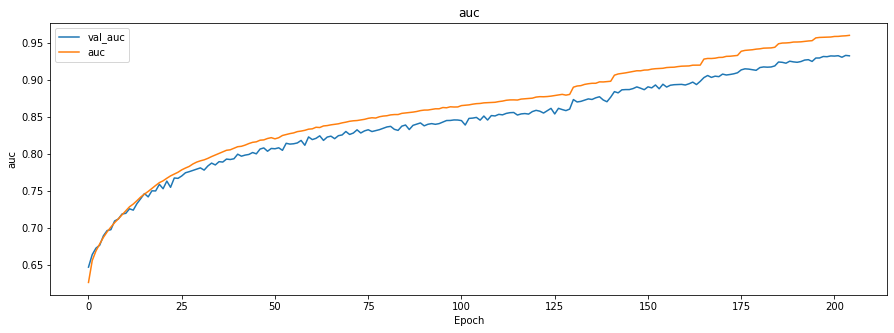

In [54]:
plt.figure(figsize=(15,5))
plt.plot(range(history1.epoch[-1]+1),history1.history['val_auc'],label='val_auc')
plt.plot(range(history1.epoch[-1]+1),history1.history['auc'],label='auc')
plt.title('auc'); plt.xlabel('Epoch'); plt.ylabel('auc');plt.legend(); 
plt.show()

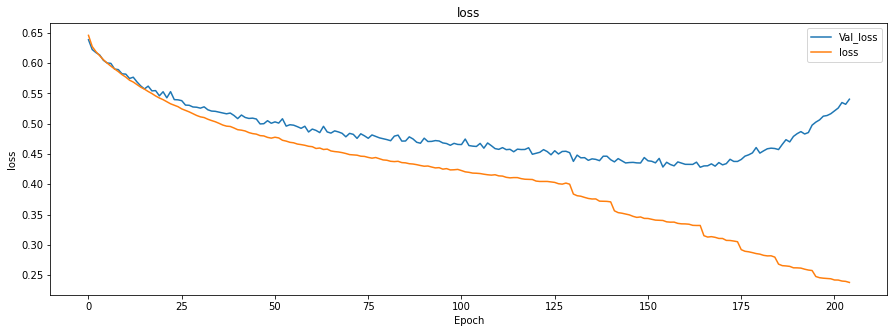

In [55]:
plt.figure(figsize=(15,5))
plt.plot(range(history1.epoch[-1]+1),history1.history['val_loss'],label='Val_loss')
plt.plot(range(history1.epoch[-1]+1),history1.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

### ROC Curve

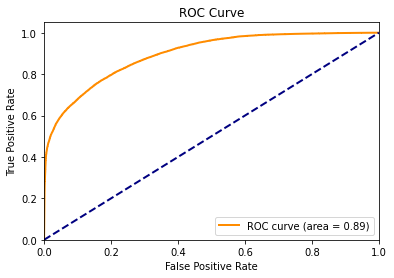

In [56]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
generate_results(y_test, y_pred)